In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from math import floor
import imageio

from matplotlib import pyplot as plt
from tqdm import tqdm
tf.config.run_functions_eagerly(True)
#tf.compat.v1.enable_eager_execution()

# HyperParameters definition

In [2]:
epochs = 10
batch_size = 8
lr = 1e-3

alpha = 0.1

resize_height = 256
resize_width = 256

ratio = 4
train_val_split_perc = 0.8
val_test_split_perc = 0.5

# Dateset split

In [3]:
img_paths = []
train_img_paths = []
val_img_paths = []
test_img_paths = []

test_img2k_paths = []

for dirname, _, filenames in os.walk('../input/div2k-augmentation/DIV2K_augmentation/DIV2K_crop'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))

        
for dirname, _, filenames in os.walk('../input/div2k-augmentation/DIV2K_augmentation/DIV2K_valid_HR/DIV2K_valid_HR'):
    for filename in filenames:
        test_img2k_paths.append(os.path.join(dirname, filename))


val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
train_img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]

test_img_paths = val_img_paths[floor(len(val_img_paths) * val_test_split_perc):]
val_img_paths = val_img_paths[:floor(len(val_img_paths) * val_test_split_perc)]

print('Dataset dimension: ', len(img_paths))
print('Training: ', len(train_img_paths))
print('Validation: ', len(val_img_paths))
print('Testing: ', len(test_img_paths))
print('Testing 2K: ', len(test_img2k_paths))

Dataset dimension:  83874
Training:  67099
Validation:  8387
Testing:  8388
Testing 2K:  100


# Generator

In [4]:
class GeneratorTest(keras.utils.Sequence):
    def __init__(self, paths, ratio = 4):
        self.paths = paths
        self.ratio = ratio
        self.n_channels = 3
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        ID = self.paths[index]
        y = imageio.imread(ID).astype(np.float32) / 255.0
        dim = (y.shape[0]//self.ratio,y.shape[1]//self.ratio)
        x = tf.keras.utils.img_to_array(tf.keras.utils.load_img(ID,target_size = (*dim, self.n_channels), interpolation = 'bicubic'))/255
        return x, y
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)


In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, ratio = 4, batch_size = 8, img_dim = (256,256), n_channels = 3, shuffle = True):
        'Initialization'
        self.dim = img_dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.ratio = ratio
        self.n_channels = n_channels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        x, y = self.__data_generation(list_IDs_temp)

        return x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        dim = (self.dim[0]//self.ratio,self.dim[1]//self.ratio)
        x = np.empty((self.batch_size, *dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            y[i,] = tf.keras.utils.img_to_array(tf.keras.utils.load_img(ID,target_size = (*self.dim, self.n_channels), interpolation = 'bicubic'))/255
            x[i,] = tf.keras.utils.img_to_array(tf.keras.utils.load_img(ID,target_size = (*dim, self.n_channels), interpolation = 'bicubic'))/255

        return x,y

In [6]:
train_dataset = DataGenerator(img_paths,ratio = ratio)
val_dataset = DataGenerator(val_img_paths, ratio = ratio)

(8, 64, 64, 3)
(8, 256, 256, 3)


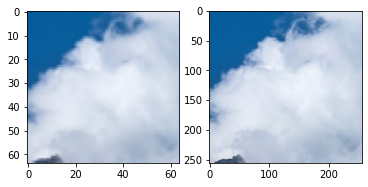

In [9]:
x,y = train_dataset[0]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x[0])
plt.subplot(1,2,2)
plt.imshow(y[0])
print(x.shape)
print(y.shape)

# Custom Loss function definition

In [10]:
@tf.function
def MeanGradientError(targets, outputs):

    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

    # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # square
    output_gradients = tf.math.add(output_gradient_x, output_gradient_y)
    target_gradients = tf.math.add(target_gradient_x, target_gradient_y)

    # compute mean gradient error
    mge = tf.keras.metrics.mean_absolute_error(output_gradients, target_gradients)

    return mge

In [11]:
@tf.function
def overall_loss_func(y_true, y_pred):
    mae_loss = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mge_loss = MeanGradientError(y_true, y_pred)
    return mae_loss + alpha * mge_loss

# SRResNet

In [14]:
upsamples_per_scale = {
    2: 1,
    4: 2,
    8: 3
}

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


def upsample(x_in, num_filters):
    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = layers.Lambda(pixel_shuffle(scale=2))(x)
    return layers.PReLU(shared_axes=[1, 2])(x)


def residual_block(block_input, num_filters, momentum=0.8):
    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(block_input)
    x = layers.BatchNormalization(momentum=momentum)(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization(momentum=momentum)(x)
    x = layers.Add()([block_input, x])
    return x

def SRResNet(scale=4, num_filters=64, num_res_blocks=16):
    num_upsamples = upsamples_per_scale[scale]

    lr = layers.Input(shape=(None, None, 3))
    #x = layers.Lambda(normalize_01)(lr)

    x = layers.Conv2D(num_filters, kernel_size=9, padding='same')(lr)
    x = x_1 = layers.PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = residual_block(x, num_filters)

    x = layers.Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x_1, x])

    for _ in range(num_upsamples):
        x = upsample(x, num_filters * 4)

    sr = layers.Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    #sr = layers.Lambda(denormalize_m11)(x)

    return keras.Model(lr, sr)

In [15]:
net = SRResNet(scale=ratio)
net.summary()

2022-06-18 09:49:37.413867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 09:49:37.508762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 09:49:37.509574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 09:49:37.511311: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, None, None, 6 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

In [16]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=overall_loss_func, metrics=['mae', MeanGradientError])

In [17]:
#net.load_weights('../input/div2k-weights/modelv2_crop_256_4_100_8.hdf5')

# Training step

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose = 1, min_lr=1e-8)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1)

history = net.fit(
        x = train_dataset,
        epochs = epochs,
        verbose = 1,
        validation_data = val_dataset,
        callbacks=[reduce_lr,checkpoint,early_stopping]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
2022-06-18 09:49:41.088591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-18 09:49:41.987729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10484/10484 [==============================] - 2472s 235ms/step - loss: 0.1869 - mae: 0.0408 - MeanGradientError: 1.4606 - val_loss: 0.4085 - val_mae: 0.1860 - val_MeanGradientError: 2.2247

Epoch 00001: val_loss improved from inf to 0.40847, saving model to best_model.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
10484/10484 [==============================] - 2566s 245ms/step - loss: 0.1709 - mae: 0.0337 - MeanGradientError: 1.3723 - val_loss: 0.1744 - val_mae: 0.0361 - val_MeanGradientError: 1.3827

Epoch 00002: val_loss improved from 0.40847 to 0.17442, saving model to best_model.hdf5
Epoch 3/10
10484/10484 [==============================] - 2530s 241ms/step - loss: 0.1655 - mae: 0.0319 - MeanGradientError: 1.3363 - val_loss: 0.1643 - val_mae: 0.0315 - val_MeanGradientError: 1.3277

Epoch 00003: val_loss improved from 0.17442 to 0.16428, saving model to best_model.hdf5
Epoch 4/10
10484/10484 [==============================] - 2622s 250ms/step - loss: 0.1632 - mae: 0.0313 - MeanGradientError: 1.3189 - val_loss: 0.1765 - val_mae: 0.0336 - val_MeanGradientError: 1.4289

Epoch 00004: val_loss did not improve from 0.16428
Epoch 5/10
10484/10484 [==============================] - 2616s 250ms/step - loss: 0.1613 - mae: 0.0307 - MeanGradientError: 1.3054 - val_loss: 0.1743 - val_mae: 0.036

In [19]:
net.optimizer.lr.numpy()

0.00051200006

## Save weights and history

In [20]:
filename = f'_{resize_width}_{ratio}_{epochs}_{batch_size}'
weights_path = 'weights' + filename + '.h5'
#net.save_weights(weights_path)

#net.save('model15.h5')

history_path = 'history' + filename + '.npy'
np.save(history_path,history.history)

## Load weights

In [21]:
filename = f'_{256}_{4}_{1000}_{8}'
weights = 'weights' + filename + '.h5'

weights_dir = '../input/div2k-weights/weights/'

print(os.path.join(weights_dir,weights))
#net.load_weights(os.path.join(weights_dir,weights))
#net.load_weights(r'../input/div2k-weights/weights/weights/weigths_256_4_1000_8.h5')

#loaded_model = tf.keras.models.load_model('./model15.h5')

#history=np.load('../input/div2k-weights/historyv2_crop_256_4_100_8.npy',allow_pickle='TRUE').item()

../input/div2k-weights/weights/weights_256_4_1000_8.h5


In [22]:
net.optimizer.lr.numpy()

0.00051200006

# Visualization of training curves

In [23]:
def plot_history(history):
    plt.figure()
    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()
    plt.savefig('loss.png', transparent = False, facecolor = 'white')

    plt.figure()
    plt.plot(history['mae'], label='train')
    plt.plot(history['val_mae'], label='val')
    plt.title('MAE')
    plt.legend()
    plt.savefig('mae.png', transparent = False, facecolor = 'white')


    plt.figure()
    plt.plot(history['MeanGradientError'], label='train')
    plt.plot(history['val_MeanGradientError'], label='val')
    plt.title('MGE')
    plt.legend()
    plt.savefig('mge.png', transparent = False, facecolor = 'white')


    plt.figure()
    plt.plot(history['lr'], label='lr')
    plt.title('Learning Rate')
    plt.legend()
    plt.savefig('lr.png', transparent = False, facecolor = 'white')


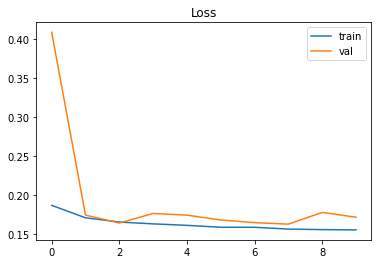

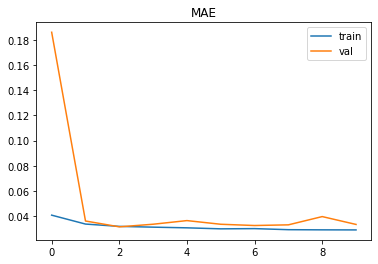

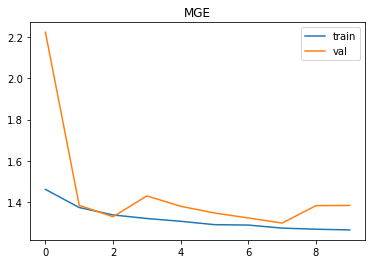

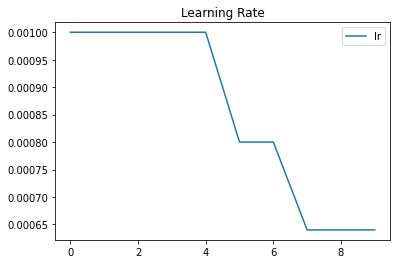

In [24]:
plot_history(history.history)

# Testing

### Testing crop

In [25]:
test_dataset = DataGenerator(test_img_paths[:5000], ratio = ratio, batch_size = 1, shuffle = False)
outputs = net.predict(test_dataset)

2022-06-18 17:15:57.613459: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3932160000 exceeds 10% of free system memory.


# Plot

In [26]:
def plot_images(low,predicted,high):
    plt.figure(figsize=(30,30))
    plt.subplot(1,3,1)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,2)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.subplot(1,3,3)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.savefig('test.png', transparent = False, facecolor = 'white')

    #plt.show()

((1, 64, 64, 3), (1, 256, 256, 3), (256, 256, 3))


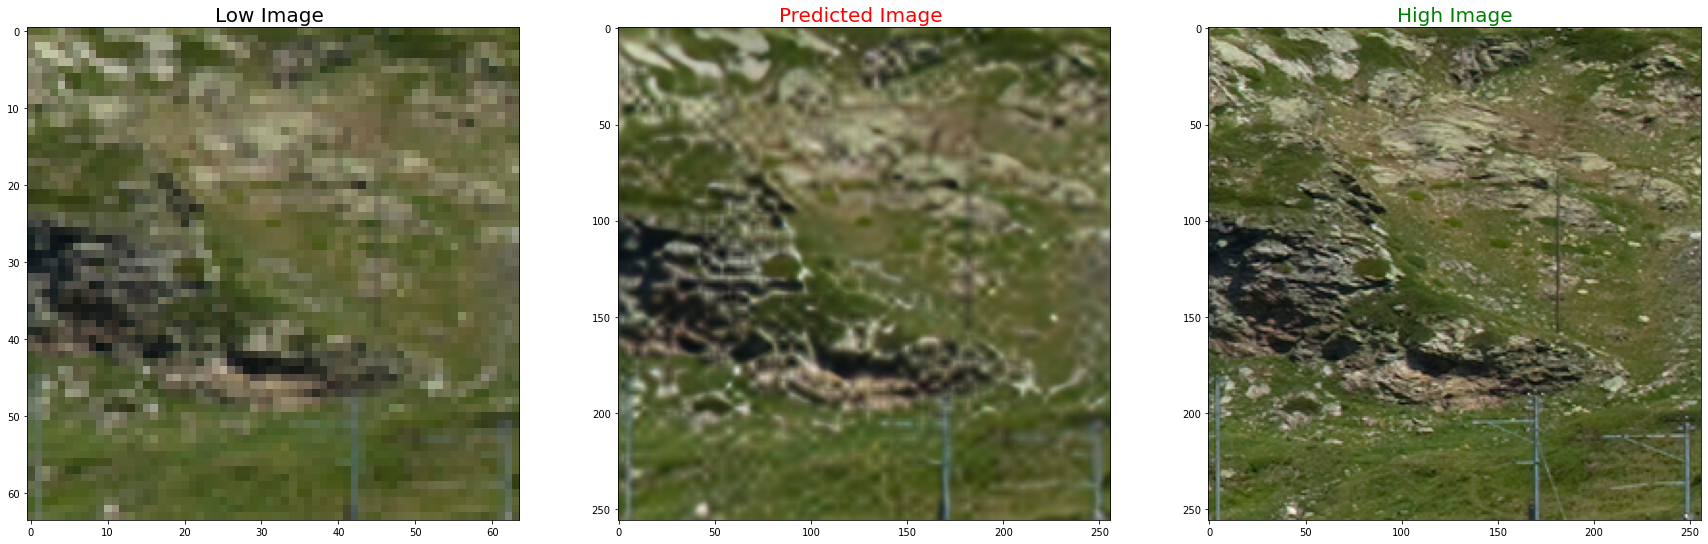

In [27]:
# x immagine input
# outputs[0] immagine output
# y immagine reference
k = 1
x, y = test_dataset[k]
print((x.shape,y.shape,outputs[k].shape))
plot_images(x[0],outputs[k],y[0])

# Metriche

## SAM

In [28]:
!pip install sewar

  Preparing metadata (setup.py) ... - done
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=424a3e0cb35a6e46073437ad998e98b48b3cf8d5c1512c0717239366c04dd327
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [29]:
import sewar as sw

### Mean angle

In [30]:
angles = []
for i in tqdm(range(len(outputs))):
    x, y = test_dataset[i]
    y = np.squeeze(y)
    angle = sw.sam(outputs[i],y)
    if not(np.isnan(angle)):
        angles.append(angle)
print('Mean angle: ' + str(sum(angles)/len(angles)))

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)
 83%|████████▎ | 4173/5000 [01:24<00:15, 53.16it/s]/opt/conda/lib/python3.7/site-packages/sewar/full_ref.py:270: RuntimeWarning: invalid value encountered in double_scalars
  val = np.clip(np.dot(GT[:,i],P[:,i]) / (np.linalg.norm(GT[:,i])*np.linalg.norm(P[:,i])),-1,1)
100%|██████████| 5000/5000 [01:40<00:00, 49.80it/s]

Mean angle: 0.123397069434781


# Test immagini 2K

In [31]:
test2k_dataset = GeneratorTest(test_img2k_paths,ratio = ratio)

In [32]:
outputs = []
for i in tqdm(range(len(test2k_dataset))):
    x , _ = test2k_dataset[i]
    x = x[None,:]
    outputs.append(net.predict(x))

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


((510, 405, 3), (2040, 1620, 3), (1, 2040, 1620, 3))


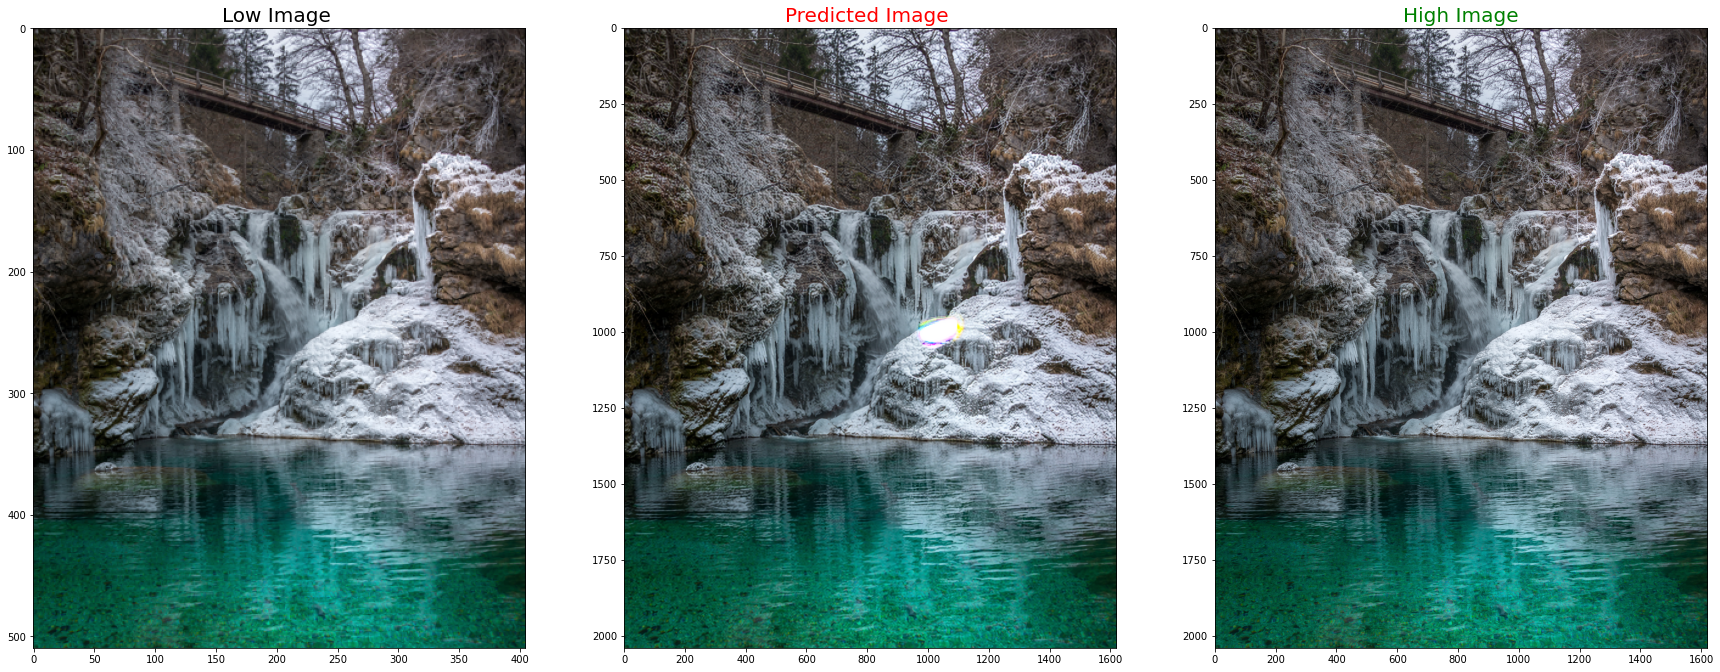

In [33]:
k = 2
x, y = test2k_dataset[k]
print((x.shape,y.shape,outputs[k].shape))
plot_images(x,np.squeeze(outputs[k]),y)

## Mean angle

In [36]:
angles = []
for i in tqdm(range(len(outputs))):
    x, y = test2k_dataset[i]
    angle = sw.sam(np.squeeze(outputs[i]),y)
    if not(np.isnan(angle)):
        angles.append(angle)
        
mean_angle = sum(angles)/len(angles)
print('Mean angle: ' + str(mean_angle) + ' rad')
print('Mean angle: ' + str(mean_angle*180/np.pi) + ' °')

100%|██████████| 100/100 [00:43<00:00,  2.30it/s]

Mean angle: 0.13918460995199597 rad
Mean angle: 7.974690723423925 °
